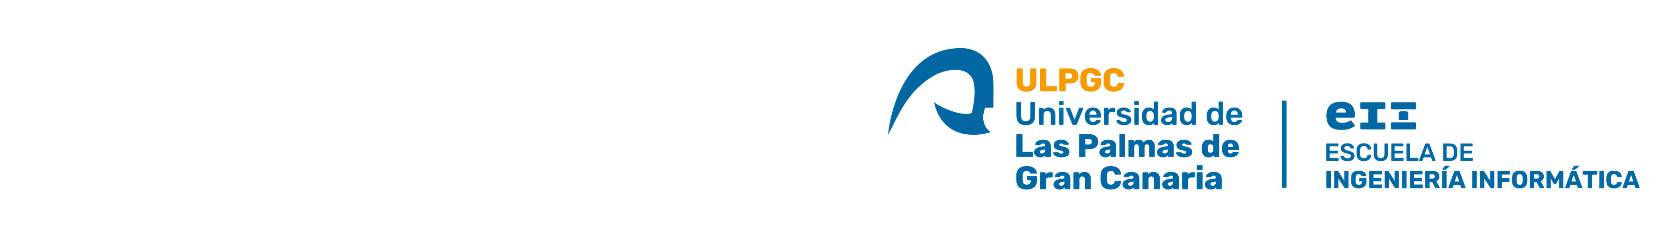




# **NOTEBOOK 9**
---

# **Estrategias de clasificación**

---

### Ejercicio 1

¿Cómo se interpretan estas métricas cuanto la classificación es multiclase?


---

En un escenario de **clasificación multiclase**, las métricas de evaluación más comunes (Accuracy, Precision, Recall y F1-Score) se interpretan de forma muy similar a como se hace en el caso binario, pero con la diferencia de que ahora existen varias clases “positivas” en lugar de una sola. A grandes rasgos, estas métricas buscan responder a preguntas como:

- **Accuracy**: “¿Con qué frecuencia acierto en la clase correcta?”
- **Precision**: “¿Entre todas mis predicciones de una clase, cuántas son correctas?”
- **Recall**: “¿Entre todos los ejemplos que realmente pertenecen a una clase, cuántos predije correctamente?”
- **F1-Score**: “¿Cómo se balancean la Precision y el Recall?”

Cuando se tienen múltiples clases, se toman dos enfoques principales para reportar y analizar estas métricas:

1. **Reportar métricas por clase**  
   Se considera cada clase como “positiva” y todas las demás como “negativas”. De esta manera, se obtiene un conjunto de valores de Precision, Recall y F1-Score específicos para cada clase. Esto resulta muy útil para diagnosticar qué clases se están prediciendo mejor o peor, pues se puede ver, por ejemplo, que se tiene una excelente precisión para la clase A pero un recall más bajo para la clase B.

2. **Proporcionar un solo valor (promediado) para cada métrica**  
   Para conseguir un valor único que represente el rendimiento global del modelo, se calcula un promedio de las métricas por clase. Existen tres maneras habituales de hacerlo:  

   - **Micro**: Se acumulan todos los verdaderos positivos, falsos positivos y falsos negativos de todas las clases y, a partir de esas sumas totales, se calcula la métrica como si fuera un problema de clasificación binaria.  
   - **Macro**: Se calcula la métrica de forma independiente para cada clase y luego se hace un promedio simple de esas métricas.  
   - **Ponderado (Weighted)**: Similar al macro, pero ponderando las métricas de cada clase según la frecuencia de esa clase en el conjunto de datos (es decir, su número de muestras).

En la práctica, es habitual reportar tanto la métrica por clase como el promedio macro o ponderado, especialmente si el conjunto de datos está desbalanceado. Por ejemplo, el **macro-F1** da la misma importancia a cada clase, mientras que el **F1 ponderado** toma en cuenta la relevancia de cada clase según cuántos ejemplos de esa clase hay. Esto permite una visión más completa de qué tan bien está funcionando el modelo en cada una de las clases y a nivel global.

---

### Ejercicio 2

Realiza la clasificación del dataset "20 Newsgroups". Para ello, usa el clasificador Naive Bayes y Regresión Logística. Compara los resultados obtenidos. Busca la configuración óptima de parámetros para cada clasificador. Intenta mejorar los resultados obtenidos con otros clasificadores que puedas encontrar en la librería Scikit-Learn. Reporta la mejor solución de todas.

---

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

In [4]:
X_train = newsgroups_train.data
y_train = newsgroups_train.target

X_test = newsgroups_test.data
y_test = newsgroups_test.target

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron, LogisticRegression
import pandas as pd

def evaluate_classifier(model, X_train, y_train, X_test, y_test):
    vectorizer = CountVectorizer(stop_words='english', max_features=50000)
    
    pipeline = Pipeline([
        ('vect', vectorizer),
        ('clf', model)
    ])
    
    pipeline.fit(X_train, y_train)
    
    predictions = pipeline.predict(X_test)
    
    report = classification_report(y_test, predictions, output_dict=True)

    accuracy = accuracy_score(y_test, predictions)
    
    df_formatted_results = []
    for label in report.keys():
        if label.isdigit() or label == 'macro avg' or label == 'weighted avg':
            if label.isdigit():
                label_name = newsgroups_train.target_names[int(label)]
            else:
                label_name = label  # Si es 'avg' o 'weighted avg', mantener el label original
            
            df_formatted_results.append({
                'Label': label_name,
                'Precision': report[label]['precision'],
                'Recall': report[label]['recall'],
                'F1-Score': report[label]['f1-score'],
                'Support': report[label]['support']
            })
    
    df_formatted_results = pd.DataFrame(df_formatted_results)

    return accuracy, df_formatted_results

In [6]:
from sklearn.model_selection import GridSearchCV

def search_grid(classifiers, param_grids, X_train, y_train, X_test, y_test):
    results = []

    for (name, model), param_grid in zip(classifiers, param_grids):
        pipeline = Pipeline([
            ('vect', CountVectorizer(stop_words='english', max_features=50000)),
            ('clf', model)
        ])

        grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_

        accuracy, df_formatted_results = evaluate_classifier(best_model.named_steps['clf'], X_train, y_train, X_test, y_test)

        results.append({
            'Report': df_formatted_results
        })

    # Convertir los resultados en un DataFrame
    df_results = pd.DataFrame(results)

    return accuracy, grid_search.best_params_, df_results


### MultinomialNB

MultinomialNB es un modelo de clasificación basado en el **teorema de Bayes**, diseñado para trabajar con datos representados como **frecuencias o conteos** (e.g., texto). Utiliza la **distribución multinomial** para modelar las probabilidades de las características.

**Suposición clave: "Naive"**

- **Independencia condicional**: Todas las características son independientes entre sí, dado el valor de la clase. Esta simplificación facilita los cálculos.

**Funcionamiento**

1. Entrenamiento:
   - Calcula la **probabilidad a priori** de cada clase $ P(C) $.
   - Estima la **probabilidad condicional** de cada característica $ P(x_i \mid C) $ usando frecuencias y un suavizado (Laplace).

   Fórmula de suavizado:
   $$
   P(x_i \mid C) = \frac{\text{frecuencia de } x_i \text{ en } C + \alpha}{\text{total de características en } C + \alpha \cdot \text{número de características}}
   $$

2. Predicción:
   - Aplica el teorema de Bayes:
   $$
   P(C \mid X) \propto P(C) \prod_{i=1}^{n} P(x_i \mid C)
   $$
   - Clasifica al seleccionar la clase con mayor probabilidad.

**Ventajas**
- Rápido y eficiente, incluso con datos grandes.
- Fácil de implementar.
- Funciona bien con datos categóricos y distribuciones multinomiales.

**Limitaciones**
- La suposición de independencia es poco realista en muchos casos.
- No se adapta bien a datos continuos sin discretización.


In [43]:
model = MultinomialNB()

param_grid = {
    'clf__alpha': [0.0001,0.001, 0.01, 0.1],
    'clf__fit_prior': [True, False]
}

acc, best_params, df_results = search_grid(
    [(model.__class__.__name__, model)], 
    [param_grid], 
    X_train, 
    y_train, 
    X_test, 
    y_test
)

In [ ]:
print("Model:", model.__class__.__name__)
print("Accuracy:", acc)
print("Best params:", best_params)
print(df_results.to_string(index=False))

Model: MultinomialNB
Accuracy: 0.7922198619224642
Best params: {'clf__alpha': 0.0001, 'clf__fit_prior': True}


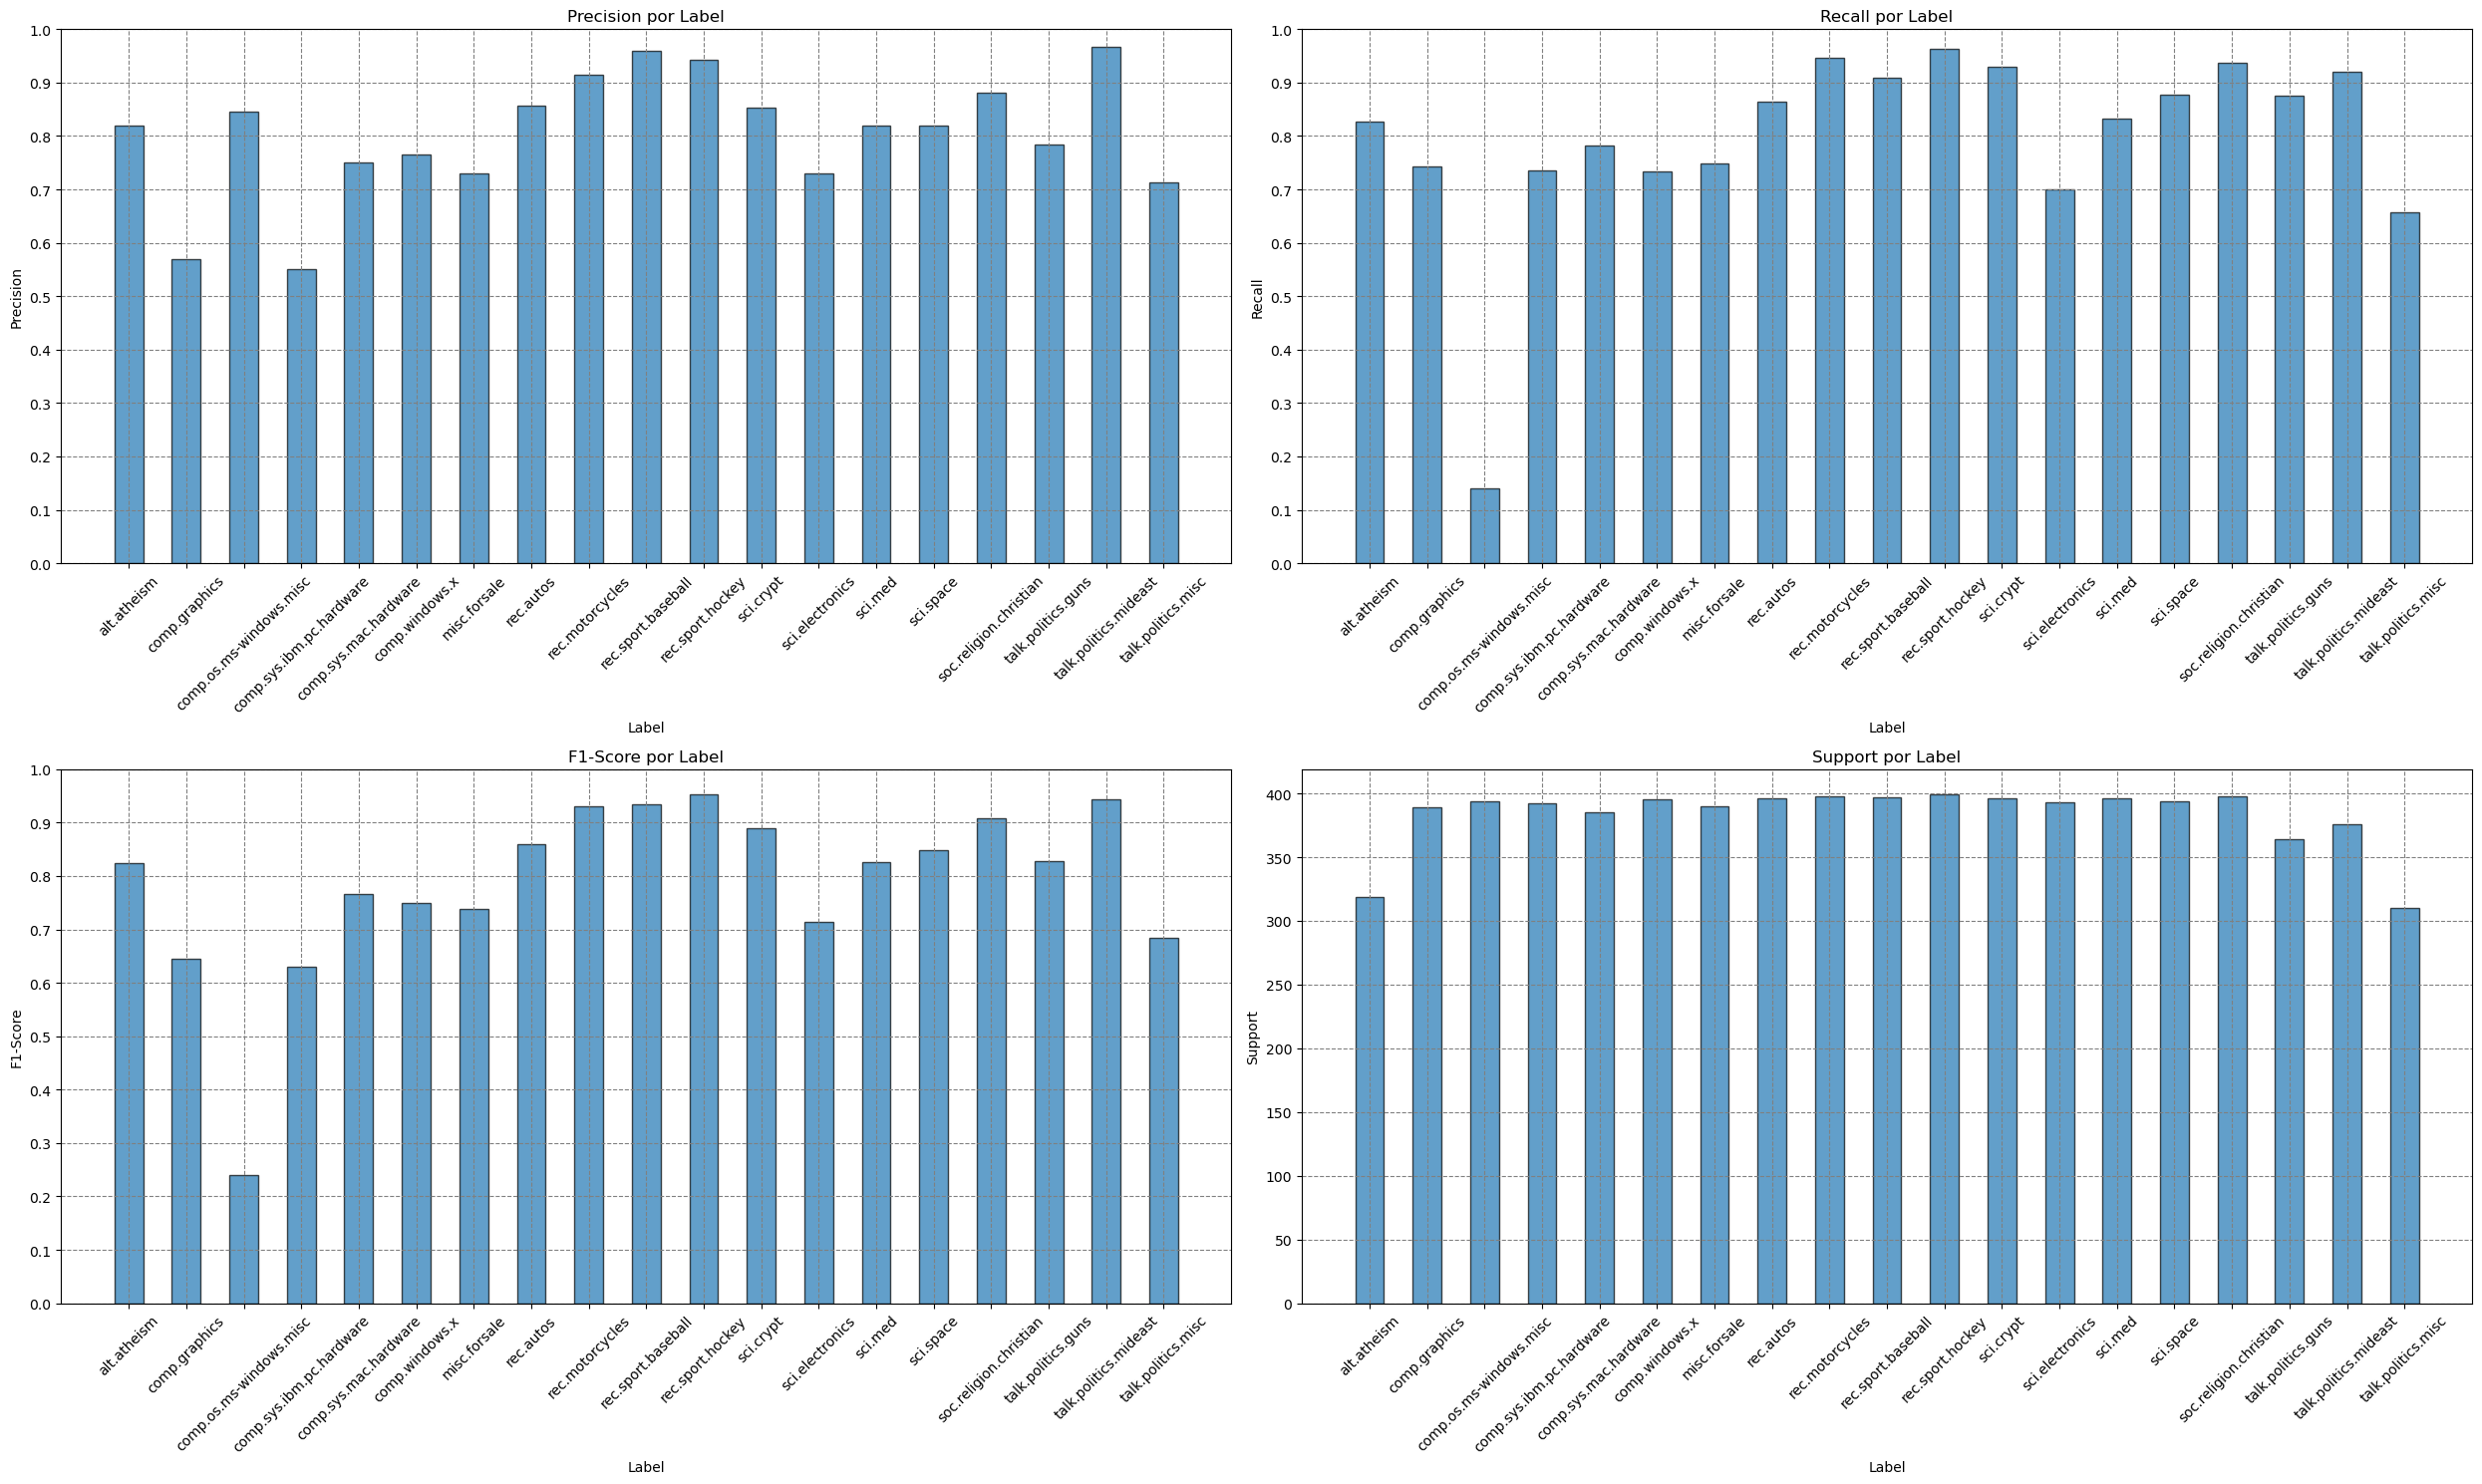

In [45]:
import matplotlib.pyplot as plt
import numpy as np

data = df_results.iloc[0]['Report']  # Asumimos un único reporte en este ejemplo
df = pd.DataFrame(data).iloc[:-3]  # Eliminar las filas 'avg' y 'weighted avg'

metrics = ['Precision', 'Recall', 'F1-Score', 'Support']
fig, axes = plt.subplots(2, 2, figsize=(25, 15))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    if i < 3:
        axes[i].set_ylim(0, 1)
        axes[i].set_yticks(np.arange(0,1.1,0.1))
    axes[i].bar(df['Label'], df[metric], width=0.5, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{metric} por Label')
    axes[i].set_xlabel('Label')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].yaxis.grid(True, color='gray', linestyle='dashed')
    axes[i].xaxis.grid(True, color='gray', linestyle='dashed')

plt.tight_layout()
plt.show()

### LogisticRegression

LogisticRegression es un modelo de clasificación que utiliza la **regresión logística** para predecir la probabilidad de pertenencia a una clase, basado en una combinación lineal de las características de entrada. Es especialmente adecuado para problemas de clasificación binaria, aunque también puede extenderse a múltiples clases.

**Funcionamiento**

1. Entrenamiento:
   - Encuentra los coeficientes $ \beta = [\beta_0, \beta_1, \dots, \beta_n] $ que maximizan la **verosimilitud** de los datos:
     $$
     P(y = 1 \mid X) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \dots + \beta_n x_n)}}
     $$
   - Esto se logra minimizando una **función de pérdida** (log-loss).

2. Predicción:
   - Calcula la probabilidad de que una muestra pertenezca a la clase positiva:
     $$
     P(y = 1 \mid X) = \frac{1}{1 + e^{-z}}
     $$
     donde $ z = \beta_0 + \sum_{i=1}^n \beta_i x_i $.
   - Clasifica asignando la clase con la mayor probabilidad.

**Ventajas**
- Interpretable: Los coeficientes indican el peso de cada característica.
- Flexible: Soporta regularización para prevenir el sobreajuste (e.g., L1, L2).
- Funciona bien en datos linealmente separables.

**Limitaciones**
- Puede tener problemas con datos no lineales si no se transforman las características (e.g., usando kernels o polinomios).
- Sensible a outliers, ya que estos pueden afectar los coeficientes.

**Regularización en LogisticRegression**
- **L1 (Lasso):** Fomenta la selección de características al reducir algunos coeficientes a cero.
- **L2 (Ridge):** Penaliza grandes coeficientes para reducir la varianza del modelo.

In [ ]:
model = LogisticRegression()
param_grid = {
    'clf__C': [0.1, 1, 10],                  
    'clf__penalty': ['l2','elasticnet'],                  
    'clf__solver': ['lbfgs', 'sag', 'saga']
}

acc, best_params, df_results = search_grid([(model.__class__.__name__, model)], [param_grid], X_train, y_train, X_test, y_test)

In [ ]:
print("Model:", model.__class__.__name__)
print("Accuracy:", acc)
print("Best params:", best_params)
print(df_results.to_string(index=False))

Model: LogisticRegression
Accuracy: 0.8033722782793414
Best params: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}


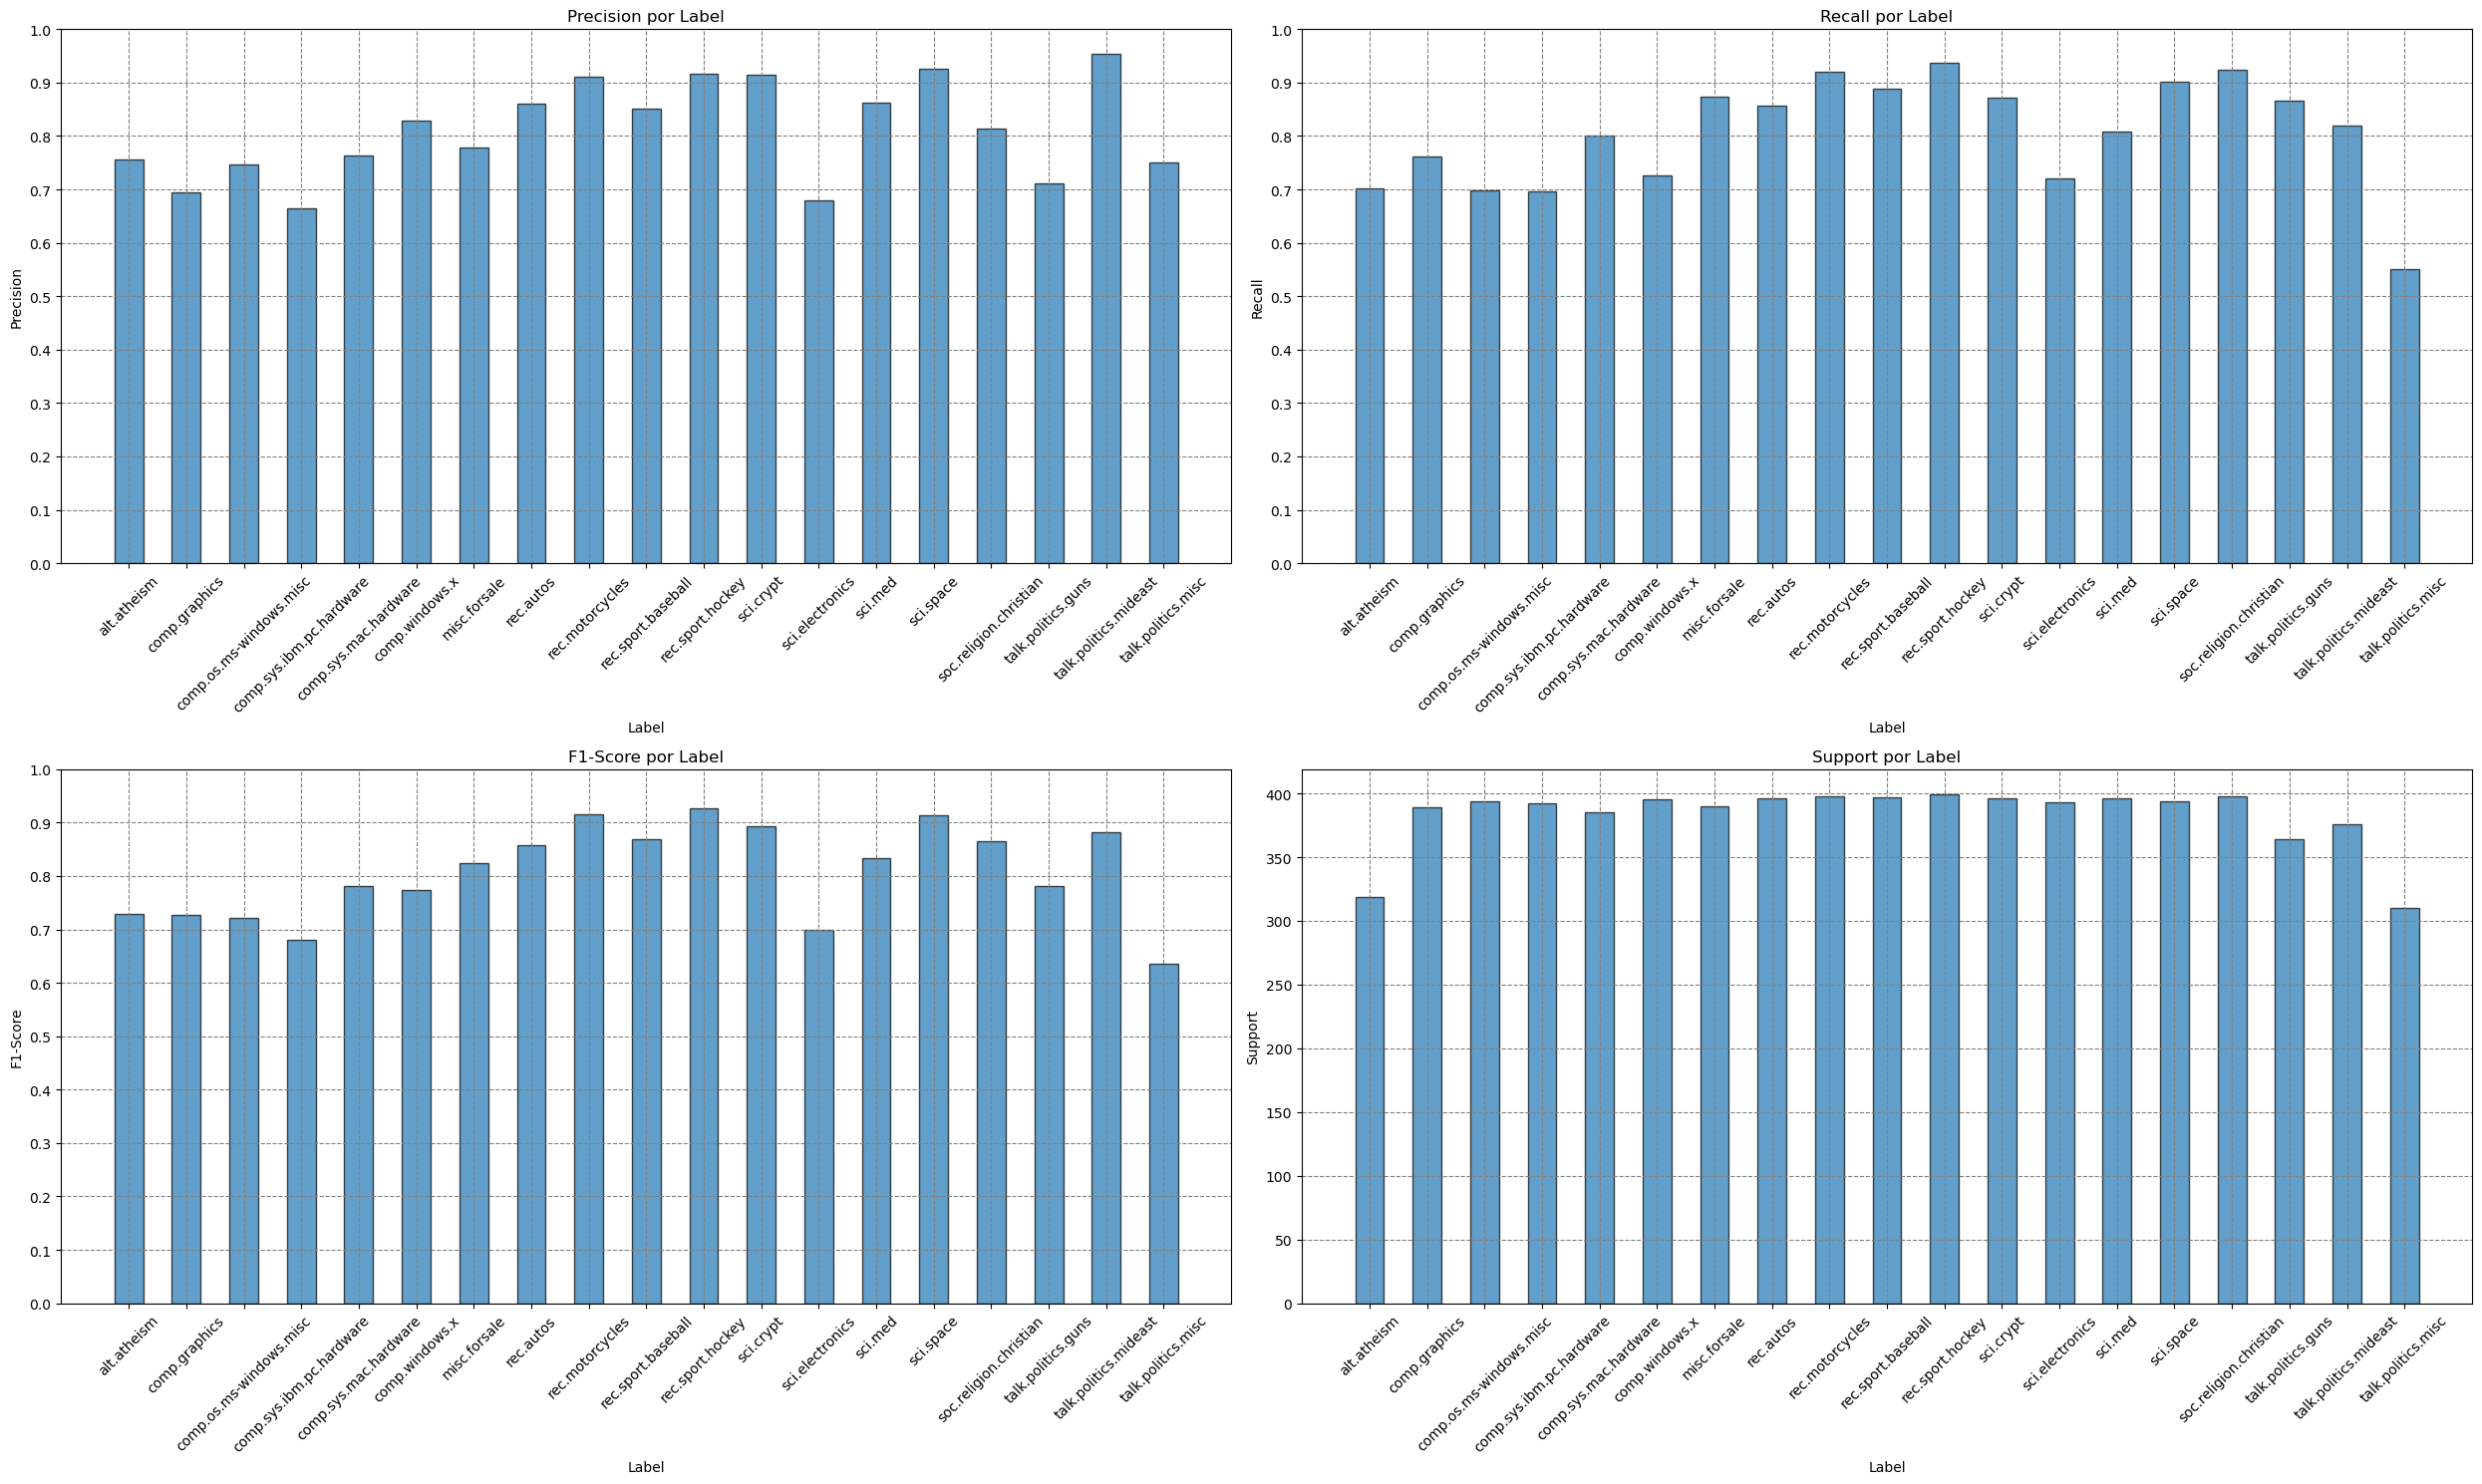

In [42]:
import matplotlib.pyplot as plt
import numpy as np

data = df_results.iloc[0]['Report']  # Asumimos un único reporte en este ejemplo
df = pd.DataFrame(data).iloc[:-3]  # Eliminar las filas 'avg' y 'weighted avg'

metrics = ['Precision', 'Recall', 'F1-Score', 'Support']
fig, axes = plt.subplots(2, 2, figsize=(25, 15))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    if i < 3:
        axes[i].set_ylim(0, 1)
        axes[i].set_yticks(np.arange(0,1.1,0.1))
    axes[i].bar(df['Label'], df[metric], width=0.5, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{metric} por Label')
    axes[i].set_xlabel('Label')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].yaxis.grid(True, color='gray', linestyle='dashed')
    axes[i].xaxis.grid(True, color='gray', linestyle='dashed')

plt.tight_layout()
plt.show()

### LinearSVC

LinearSVC es un modelo de clasificación que utiliza un **clasificador de soporte vectorial (SVC)** con un núcleo lineal. Su objetivo es encontrar un hiperplano que **maximice el margen** entre las clases en un espacio de características. Es adecuado para problemas de clasificación binaria y multiclase.

**Suposición clave: Separabilidad Lineal**

- Asume que los datos pueden ser separados (o aproximados) por un hiperplano en el espacio de características, maximizando el margen entre las clases.

**Funcionamiento**

1. Entrenamiento:
   - Encuentra un hiperplano que maximiza el margen entre las clases mediante la optimización de la siguiente función:
     $$
     \min \frac{1}{2} \lVert w \rVert^2 + C \sum_{i=1}^n \text{HingeLoss}(y_i, w \cdot x_i + b)
     $$
     Donde:
     - $ \lVert w \rVert^2 $: Penalización por la complejidad del modelo.
     - $ C $: Parámetro que controla el balance entre maximizar el margen y minimizar el error.
     - $ \text{HingeLoss} $: Función de pérdida que penaliza puntos mal clasificados o cerca del margen.

2. Predicción:
   - Clasifica las muestras según la posición relativa con respecto al hiperplano:
     $$
     f(x) = w \cdot x + b
     $$
     Si $ f(x) > 0 $, la muestra pertenece a la clase positiva; de lo contrario, a la clase negativa.

**Ventajas**
- Escalable: Funciona bien con conjuntos de datos grandes y de alta dimensionalidad.
- Flexible: Soporta regularización L2 para prevenir sobreajuste.
- Rápido: Implementación optimizada para clasificación lineal.

**Limitaciones**
- No maneja bien datos que no sean linealmente separables sin transformar las características.
- Sensible a valores atípicos que pueden influir en el hiperplano.

In [51]:
model = LinearSVC()
param_grid = {
    'clf__C': [0.001, 0.01, 0.1, 1],            
    'clf__loss': ['hinge', 'squared_hinge'],
    'clf__max_iter': [15000]
}

acc, best_params, df_results = search_grid([(model.__class__.__name__, model)], [param_grid], X_train, y_train, X_test, y_test)

/home/orr/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
print("Model:", model.__class__.__name__)
print("Accuracy:", acc)
print("Best params:", best_params)
print(df_results.to_string(index=False))

Model: LinearSVC
Accuracy: 0.8230217737652682
Best params: {'clf__C': 0.01, 'clf__loss': 'squared_hinge', 'clf__max_iter': 15000}


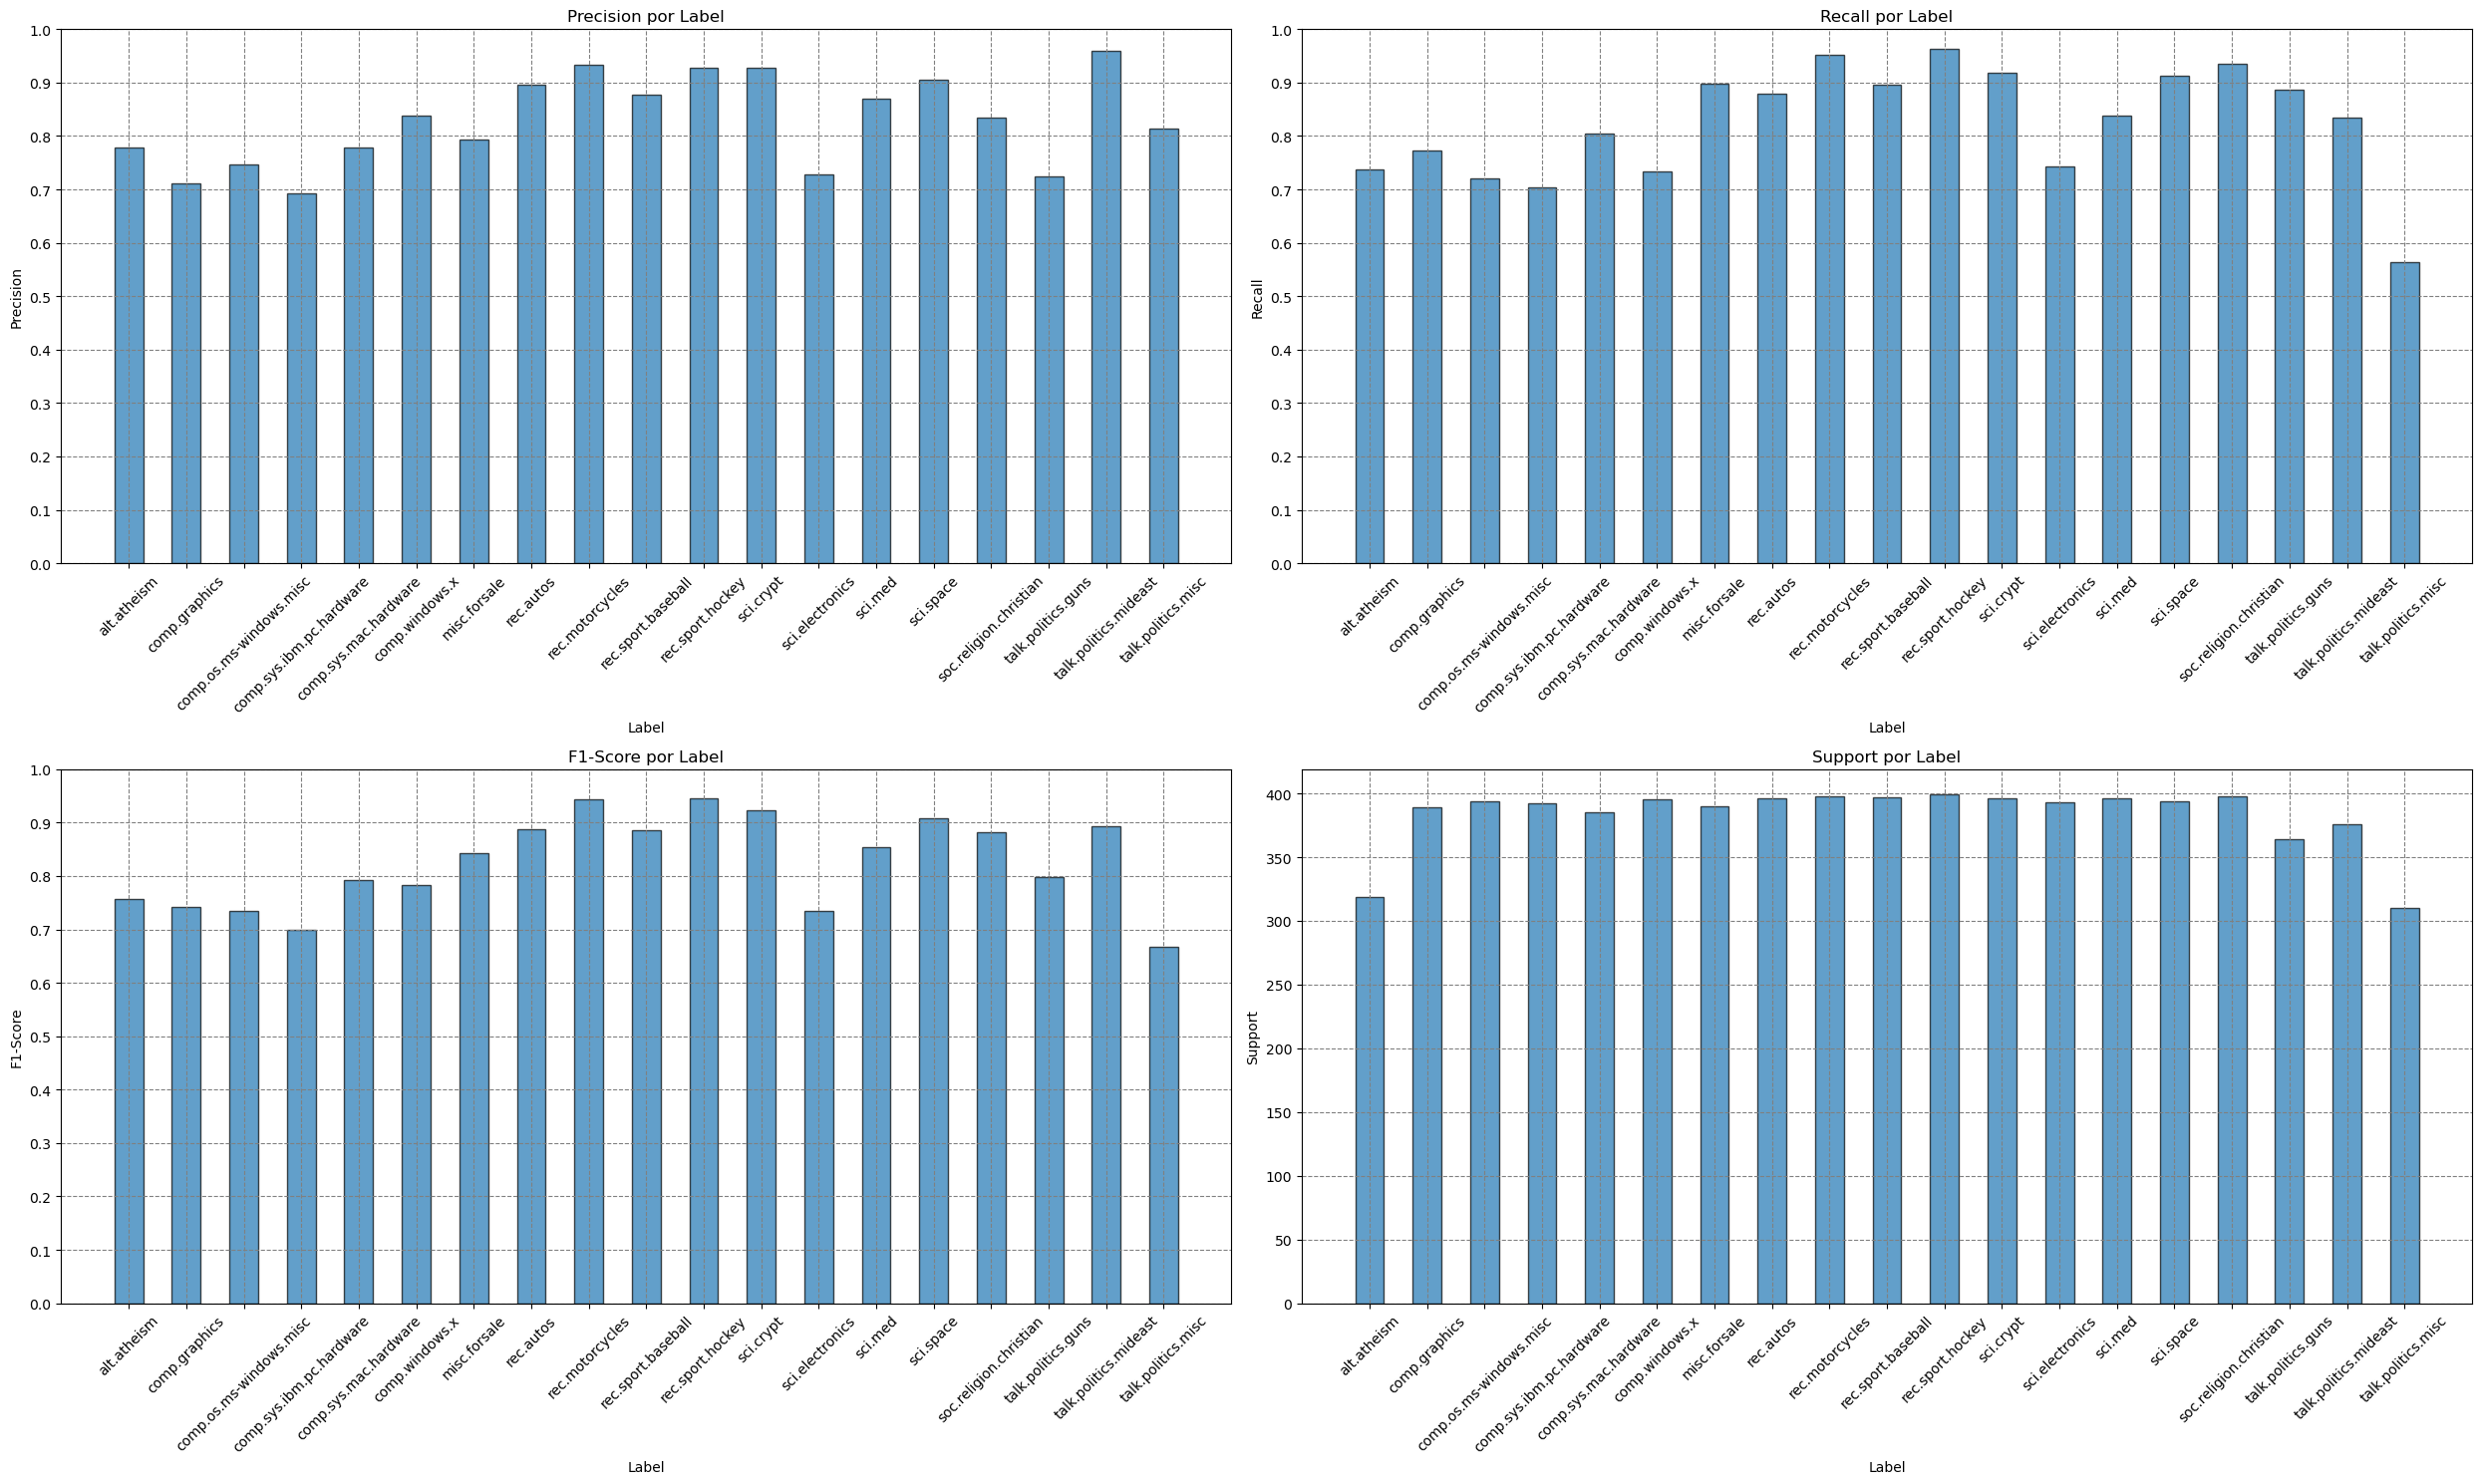

In [53]:
import matplotlib.pyplot as plt
import numpy as np

data = df_results.iloc[0]['Report']  # Asumimos un único reporte en este ejemplo
df = pd.DataFrame(data).iloc[:-3]  # Eliminar las filas 'avg' y 'weighted avg'

metrics = ['Precision', 'Recall', 'F1-Score', 'Support']
fig, axes = plt.subplots(2, 2, figsize=(25, 15))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    if i < 3:
        axes[i].set_ylim(0, 1)
        axes[i].set_yticks(np.arange(0,1.1,0.1))
    axes[i].bar(df['Label'], df[metric], width=0.5, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{metric} por Label')
    axes[i].set_xlabel('Label')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].yaxis.grid(True, color='gray', linestyle='dashed')
    axes[i].xaxis.grid(True, color='gray', linestyle='dashed')

plt.tight_layout()
plt.show()

### Perceptron

Perceptron es un modelo de clasificación lineal que utiliza un **algoritmo de aprendizaje supervisado** inspirado en las redes neuronales. Es uno de los algoritmos más simples para problemas de clasificación binaria, basado en la actualización iterativa de los pesos para encontrar un hiperplano que separa las clases.

**Funcionamiento**

1. **Entrenamiento:**
   - Inicializa los pesos ($ w $) y el sesgo ($ b $) en cero o valores pequeños.
   - Para cada muestra $ x_i $ con etiqueta $ y_i $:
     - Calcula la predicción:
       $$
       \hat{y} = \text{sign}(w \cdot x_i + b)
       $$
     - Si la predicción es incorrecta ($ \hat{y} \neq y_i $):
       - Actualiza los pesos y el sesgo:
         $$
         w \leftarrow w + \eta \cdot y_i \cdot x_i
         $$
         $$
         b \leftarrow b + \eta \cdot y_i
         $$
       Donde $ \eta $ es la tasa de aprendizaje.

2. **Predicción:**
   - Clasifica las muestras evaluando el signo de $ w \cdot x + b $:
     - Si $ w \cdot x + b > 0 $, pertenece a la clase positiva.
     - Si $ w \cdot x + b \leq 0 $, pertenece a la clase negativa.

**Ventajas**
- Simplicidad: Fácil de entender e implementar.
- Eficiencia: Rápido para datos pequeños y de dimensiones moderadas.
- Base teórica: Inspiró algoritmos más avanzados en aprendizaje automático.

**Limitaciones**
- Convergencia: Solo funciona si las clases son perfectamente separables linealmente.
- Sensible al escalado: Requiere que las características estén normalizadas o escaladas para un rendimiento óptimo.
- No es robusto frente a valores atípicos o ruido en los datos.

In [48]:
model = Perceptron()
param_grid = {
    'clf__alpha': np.arange(0.0001, 0.001, 0.01),
}

acc, best_params, df_results = search_grid([(model.__class__.__name__, model)], [param_grid], X_train, y_train, X_test, y_test)

In [49]:
print("Model:", model.__class__.__name__)
print("Accuracy:", acc)
print("Best params:", best_params)
print(df_results.to_string(index=False))

Model: Perceptron
Accuracy: 0.7415029208709506
Best params: {'clf__alpha': 0.0001}
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

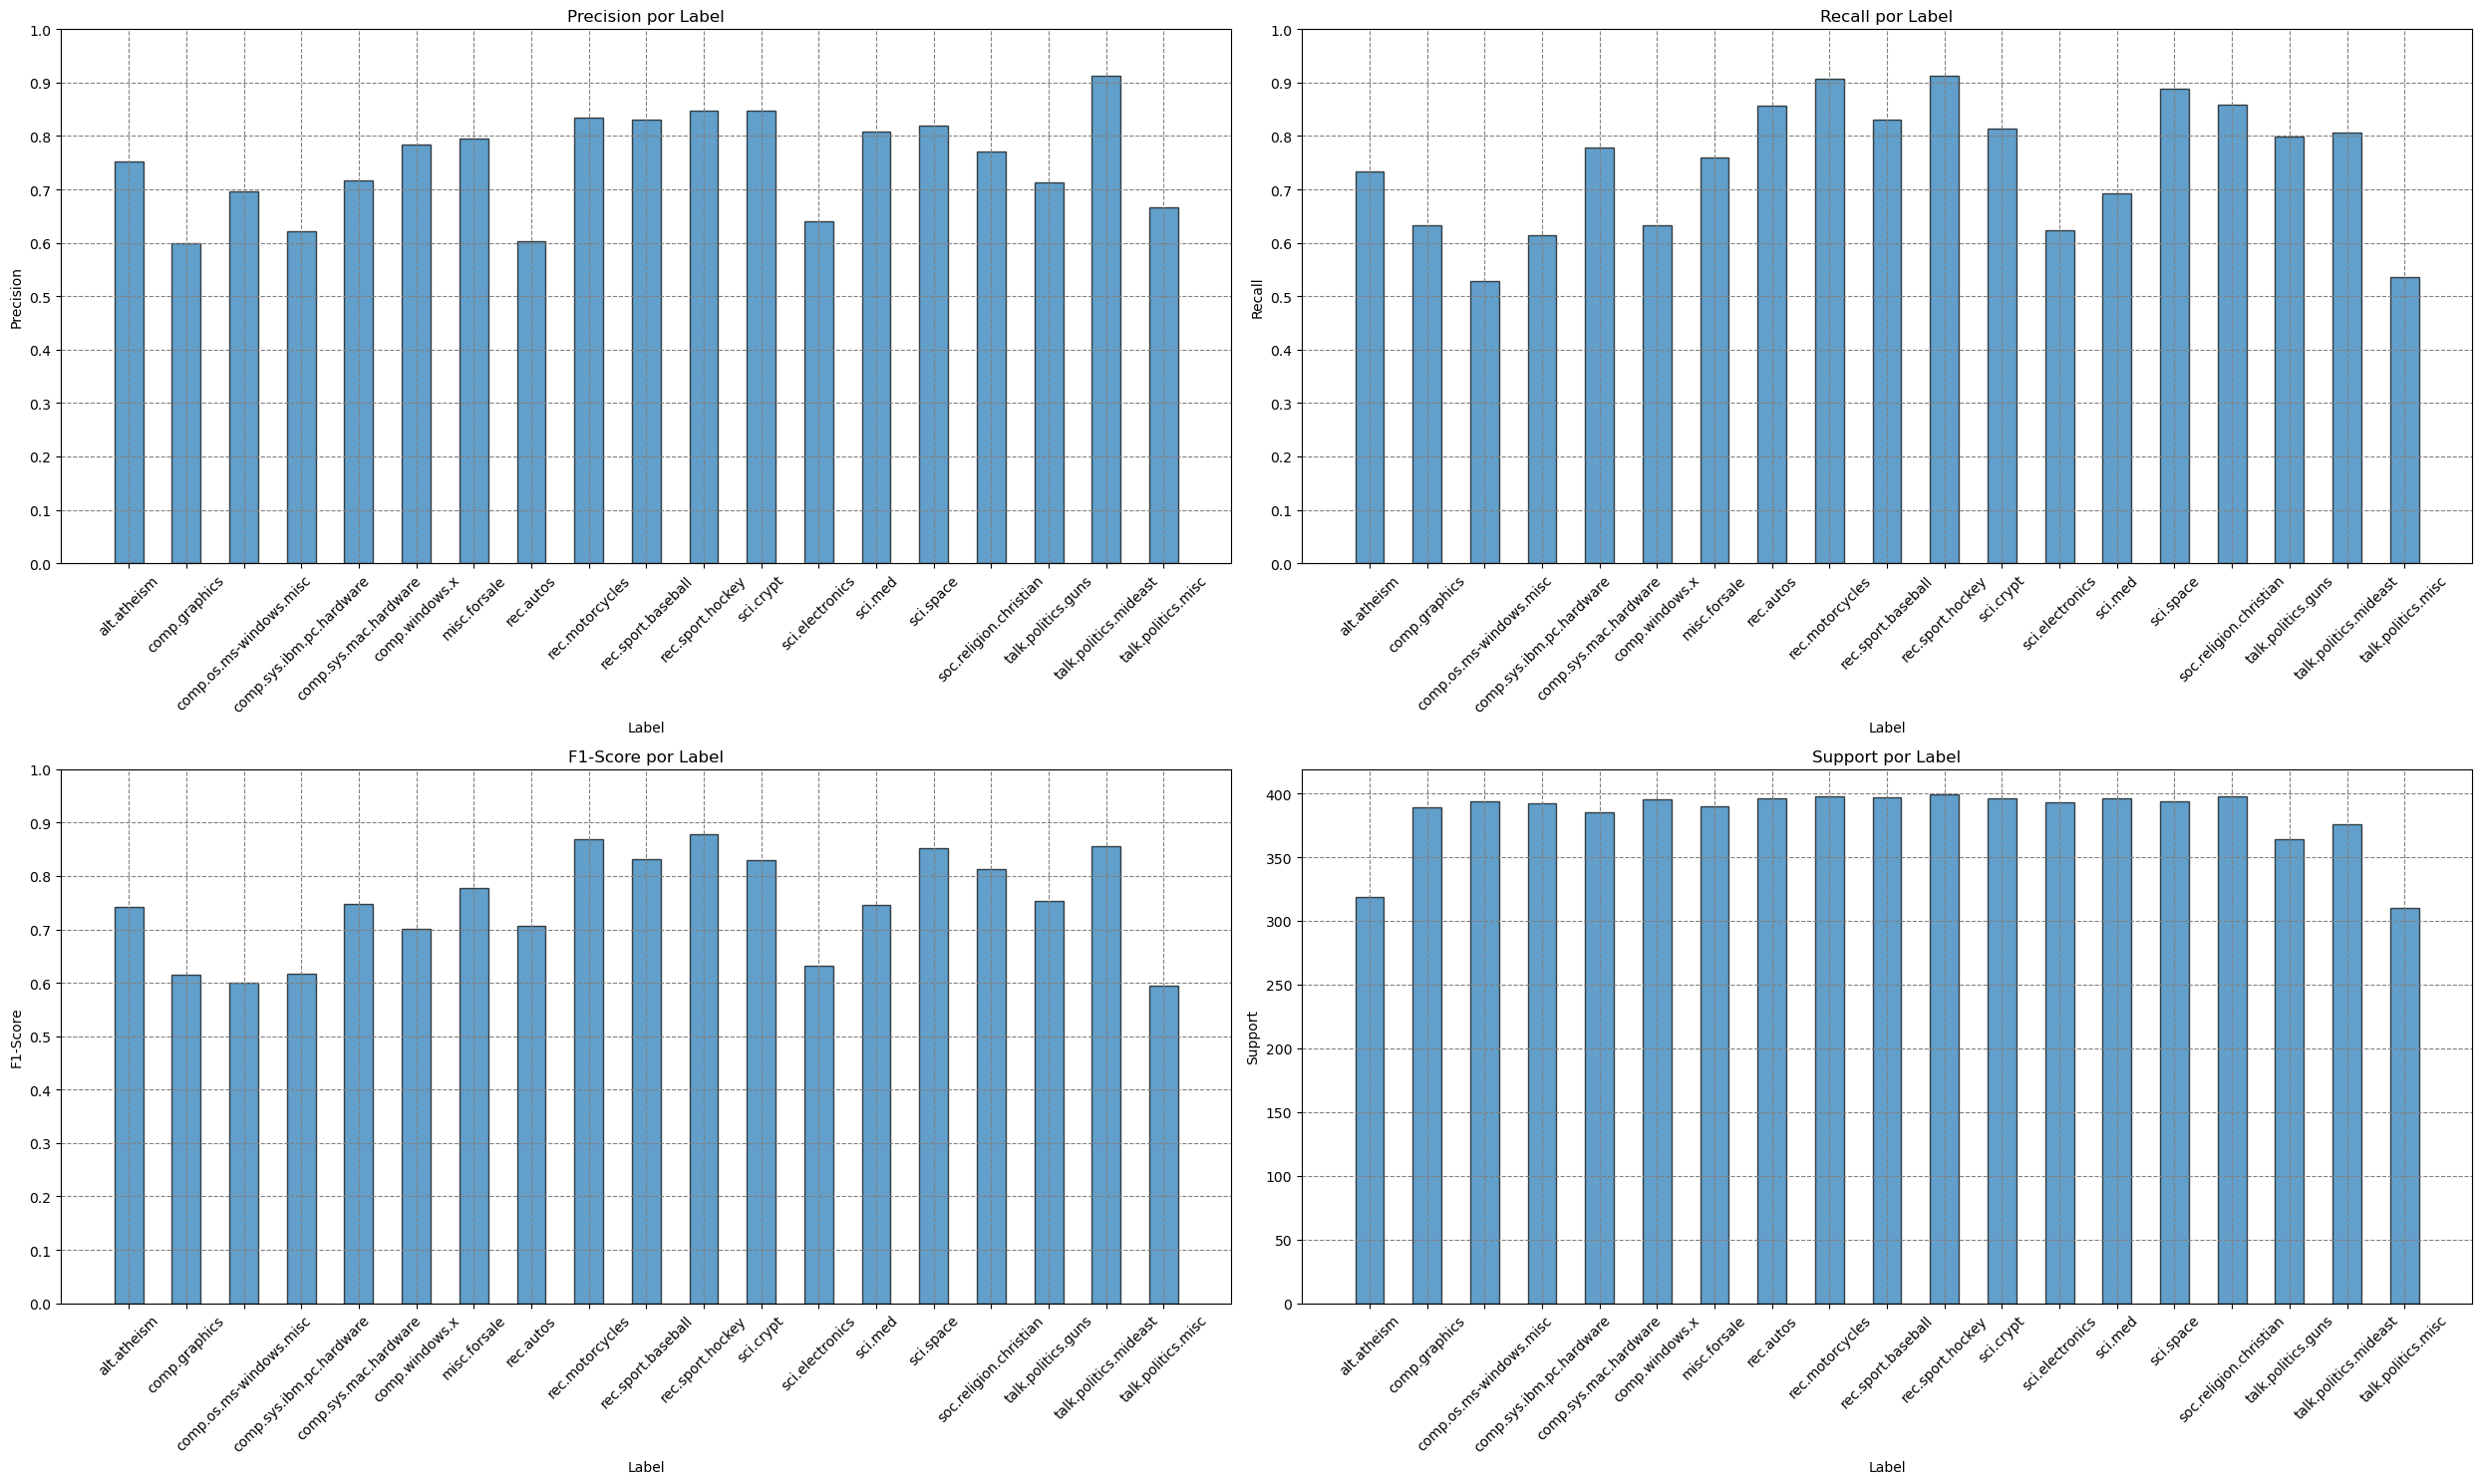

In [50]:
import matplotlib.pyplot as plt
import numpy as np

data = df_results.iloc[0]['Report']  # Asumimos un único reporte en este ejemplo
df = pd.DataFrame(data).iloc[:-3]  # Eliminar las filas 'avg' y 'weighted avg'

metrics = ['Precision', 'Recall', 'F1-Score', 'Support']
fig, axes = plt.subplots(2, 2, figsize=(25, 15))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    if i < 3:
        axes[i].set_ylim(0, 1)
        axes[i].set_yticks(np.arange(0,1.1,0.1))
    axes[i].bar(df['Label'], df[metric], width=0.5, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{metric} por Label')
    axes[i].set_xlabel('Label')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].yaxis.grid(True, color='gray', linestyle='dashed')
    axes[i].xaxis.grid(True, color='gray', linestyle='dashed')

plt.tight_layout()
plt.show()

<table style="margin: auto; text-align: center; border-collapse: collapse; width: 70%;">
  <thead>
    <tr>
      <th style="border: 1px solid black;">Modelo</th>
      <th style="border: 1px solid black;">Accuracy</th>
      <th style="border: 1px solid black;">Principales Hiperparámetros</th>
    </tr>
  </thead>
  <tbody>
      <tr>
      <td style="border: 1px solid black;">LinearSVC</td>
      <td style="border: 1px solid black;">0.8230</td>
      <td style="border: 1px solid black;">C=0.01, loss='squared_hinge', max_iter=15000</td>
    </tr>
    <tr>
      <td style="border: 1px solid black;">LogisticRegression</td>
      <td style="border: 1px solid black;">0.8034</td>
      <td style="border: 1px solid black;">C=1, penalty='l2', solver='lbfgs'</td>
    </tr>
    <tr>
      <td style="border: 1px solid black;">MultinomialNB</td>
      <td style="border: 1px solid black;">0.7922</td>
      <td style="border: 1px solid black;">alpha=0.0001, fit_prior=True</td>
    </tr>
    <tr>
      <td style="border: 1px solid black;">Perceptron</td>
      <td style="border: 1px solid black;">0.7415</td>
      <td style="border: 1px solid black;">alpha=0.0001</td>
    </tr>
  </tbody>
</table>


# Mejor solución: LinearSVC

La **mejor solución** reportada, de acuerdo con los experimentos presentados, es el **modelo LinearSVC** con la siguiente configuración:

- **Accuracy**: ~0.8230  
- **Parámetros**:
  - `C=0.01`
  - `loss='squared_hinge'`
  - `max_iter=15000`

## Reporte de clasificación

<table style="margin: auto; text-align: center; border-collapse: collapse; width: 70%;">
  <thead>
    <tr>
      <th style="border: 1px solid black;">Label</th>
      <th style="border: 1px solid black;">Precision</th>
      <th style="border: 1px solid black;">Recall</th>
      <th style="border: 1px solid black;">F1-Score</th>
      <th style="border: 1px solid black;">Support</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border: 1px solid black;">alt.atheism</td>
      <td style="border: 1px solid black;">0.778146</td>
      <td style="border: 1px solid black;">0.736677</td>
      <td style="border: 1px solid black;">0.756844</td>
      <td style="border: 1px solid black;">319.0</td>
    </tr>
    <tr>
      <td style="border: 1px solid black;">comp.graphics</td>
      <td style="border: 1px solid black;">0.711584</td>
      <td style="border: 1px solid black;">0.773779</td>
      <td style="border: 1px solid black;">0.741379</td>
      <td style="border: 1px solid black;">389.0</td>
    </tr>
    <tr>
      <td style="border: 1px solid black;">comp.os.ms-windows.misc</td>
      <td style="border: 1px solid black;">0.747368</td>
      <td style="border: 1px solid black;">0.720812</td>
      <td style="border: 1px solid black;">0.733850</td>
      <td style="border: 1px solid black;">394.0</td>
    </tr>
    <tr>
      <td style="border: 1px solid black;">comp.sys.ibm.pc.hardware</td>
      <td style="border: 1px solid black;">0.693467</td>
      <td style="border: 1px solid black;">0.704082</td>
      <td style="border: 1px solid black;">0.698734</td>
      <td style="border: 1px solid black;">392.0</td>
    </tr>
    <tr>
      <td style="border: 1px solid black;">comp.sys.mac.hardware</td>
      <td style="border: 1px solid black;">0.778894</td>
      <td style="border: 1px solid black;">0.805195</td>
      <td style="border: 1px solid black;">0.791826</td>
      <td style="border: 1px solid black;">385.0</td>
    </tr>
    <tr>
      <td style="border: 1px solid black;">comp.windows.x</td>
      <td style="border: 1px solid black;">0.838150</td>
      <td style="border: 1px solid black;">0.734177</td>
      <td style="border: 1px solid black;">0.782726</td>
      <td style="border: 1px solid black;">395.0</td>
    </tr>
    <tr>
      <td style="border: 1px solid black;">misc.forsale</td>
      <td style="border: 1px solid black;">0.793651</td>
      <td style="border: 1px solid black;">0.897436</td>
      <td style="border: 1px solid black;">0.842359</td>
      <td style="border: 1px solid black;">390.0</td>
    </tr>
    <tr>
      <td style="border: 1px solid black;">rec.autos</td>
      <td style="border: 1px solid black;">0.896907</td>
      <td style="border: 1px solid black;">0.878788</td>
      <td style="border: 1px solid black;">0.887755</td>
      <td style="border: 1px solid black;">396.0</td>
    </tr>
    <tr>
      <td style="border: 1px solid black;">rec.motorcycles</td>
      <td style="border: 1px solid black;">0.933498</td>
      <td style="border: 1px solid black;">0.952261</td>
      <td style="border: 1px solid black;">0.942786</td>
      <td style="border: 1px solid black;">398.0</td>
    </tr>
    <tr>
      <td style="border: 1px solid black;">rec.sport.baseball</td>
      <td style="border: 1px solid black;">0.876847</td>
      <td style="border: 1px solid black;">0.896725</td>
      <td style="border: 1px solid black;">0.886675</td>
      <td style="border: 1px solid black;">397.0</td>
    </tr>
    <tr>
      <td style="border: 1px solid black;">rec.sport.hockey</td>
      <td style="border: 1px solid black;">0.927536</td>
      <td style="border: 1px solid black;">0.962406</td>
      <td style="border: 1px solid black;">0.944649</td>
      <td style="border: 1px solid black;">399.0</td>
    </tr>
    <tr>
      <td style="border: 1px solid black;">sci.crypt</td>
      <td style="border: 1px solid black;">0.928571</td>
      <td style="border: 1px solid black;">0.919192</td>
      <td style="border: 1px solid black;">0.923858</td>
      <td style="border: 1px solid black;">396.0</td>
    </tr>
    <tr>
      <td style="border: 1px solid black;">sci.electronics</td>
      <td style="border: 1px solid black;">0.728180</td>
      <td style="border: 1px solid black;">0.743003</td>
      <td style="border: 1px solid black;">0.735516</td>
      <td style="border: 1px solid black;">393.0</td>
    </tr>
    <tr>
      <td style="border: 1px solid black;">sci.med</td>
      <td style="border: 1px solid black;">0.869110</td>
      <td style="border: 1px solid black;">0.838384</td>
      <td style="border: 1px solid black;">0.853470</td>
      <td style="border: 1px solid black;">396.0</td>
    </tr>
    <tr>
      <td style="border: 1px solid black;">sci.space</td>
      <td style="border: 1px solid black;">0.904523</td>
      <td style="border: 1px solid black;">0.913706</td>
      <td style="border: 1px solid black;">0.909091</td>
      <td style="border: 1px solid black;">394.0</td>
    </tr>
    <tr>
      <td style="border: 1px solid black;">soc.religion.christian</td>
      <td style="border: 1px solid black;">0.834081</td>
      <td style="border: 1px solid black;">0.934673</td>
      <td style="border: 1px solid black;">0.881517</td>
      <td style="border: 1px solid black;">398.0</td>
    </tr>
    <tr>
      <td style="border: 1px solid black;">talk.politics.guns</td>
      <td style="border: 1px solid black;">0.724215</td>
      <td style="border: 1px solid black;">0.887363</td>
      <td style="border: 1px solid black;">0.797531</td>
      <td style="border: 1px solid black;">364.0</td>
    </tr>
    <tr>
      <td style="border: 1px solid black;">talk.politics.mideast</td>
      <td style="border: 1px solid black;">0.960245</td>
      <td style="border: 1px solid black;">0.835106</td>
      <td style="border: 1px solid black;">0.893314</td>
      <td style="border: 1px solid black;">376.0</td>
    </tr>
    <tr>
      <td style="border: 1px solid black;">talk.politics.misc</td>
      <td style="border: 1px solid black;">0.813953</td>
      <td style="border: 1px solid black;">0.564516</td>
      <td style="border: 1px solid black;">0.666667</td>
      <td style="border: 1px solid black;">310.0</td>
    </tr>
    <tr>
      <td style="border: 1px solid black;">talk.religion.misc</td>
      <td style="border: 1px solid black;">0.690583</td>
      <td style="border: 1px solid black;">0.613546</td>
      <td style="border: 1px solid black;">0.649789</td>
      <td style="border: 1px solid black;">251.0</td>
    </tr>
    <tr>
      <td style="border: 1px solid black;"><strong>macro avg</strong></td>
      <td style="border: 1px solid black;">0.821475</td>
      <td style="border: 1px solid black;">0.815591</td>
      <td style="border: 1px solid black;">0.816017</td>
      <td style="border: 1px solid black;">7532.0</td>
    </tr>
    <tr>
      <td style="border: 1px solid black;"><strong>weighted avg</strong></td>
      <td style="border: 1px solid black;">0.824939</td>
      <td style="border: 1px solid black;">0.823022</td>
      <td style="border: 1px solid black;">0.821692</td>
      <td style="border: 1px solid black;">7532.0</td>
    </tr>
  </tbody>
</table>

## Conclusiones

- **Exactitud**: El modelo **LinearSVC** registró la *accuracy* más alta, con un valor de **0.823**.  

- **F1-Scores altos**: Clases como  
  - __rec.motorcycles__ (0.9428)  
  - __rec.sport.hockey__ (0.9446)  
  - __talk.politics.mideast__ (0.8933)  
  consiguieron F1-Scores especialmente destacados. Esto indica que el clasificador manejó mejor las temáticas con menor ambigüedad léxica y con un contexto temático más definido.

- **Clases con mayor dificultad**: En particular,  
  - __talk.religion.misc__ alcanzó un F1-Score de 0.6498,  
  - __talk.politics.misc__ se situó en 0.6667,  
  sugiriendo que algunos documentos dentro de estas categorías presentan términos que se solapan con otros temas, dificultando la clasificación.

- **Visión global**: El *macro avg* alcanzó un F1-Score de **0.816**, mientras que el *weighted avg* fue de **0.822**, reflejando un buen desempeño en la mayoría de las categorías.